k-Nearest Neighbours is a model often employed for classification, which, given k, assigns each observation to the majority class of its k nearest neighbours. It is called a lazy learner, as it only comes up with predictions when prompted. Therefore, the computation could take some time, and it is not the best model in situations in which fast predictions are needed. Nonetheless, it is worth a try, due to its simplicity of understanding and employment.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import datasets
X_train = pd.read_csv('/Users/alessia/Desktop/churn/X_train.csv')
y_train = pd.read_csv('/Users/alessia/Desktop/churn/y_train.csv')
X_test = pd.read_csv('/Users/alessia/Desktop/churn/X_test.csv')
y_test = pd.read_csv('/Users/alessia/Desktop/churn/y_test.csv')

In [3]:
# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# KNN model
knn = KNeighborsClassifier(weights='distance')
param_grid = {'n_neighbors': range(31, 52, 2)} 
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train.values.ravel())

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: ", grid_search.best_score_)

Best Parameters:  {'n_neighbors': 51}
Best AUC:  0.872096977918504


In [5]:
# evaluate knn on the test set
best_knn = grid_search.best_estimator_
test_accuracy = best_knn.score(X_test_scaled, y_test)
print("Test Accuracy: ", test_accuracy)

# AUC test scores
y_probs_test = best_knn.predict_proba(X_test_scaled)[:, 1]
y_probs_train = best_knn.predict_proba(X_train_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_probs_test)
train_auc = roc_auc_score(y_train, y_probs_train)
print("AUC on Test Set: {:.4f}".format(test_auc))
print("AUC on Training Set: {:.4f}".format(train_auc))

Test Accuracy:  0.8579484686436558
AUC on Test Set: 0.8755
AUC on Training Set: 1.0000


In [6]:
# confusion matrix
import seaborn as sns

classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [7]:
# predict on test set
y_pred_test = best_knn.predict(X_test_scaled)

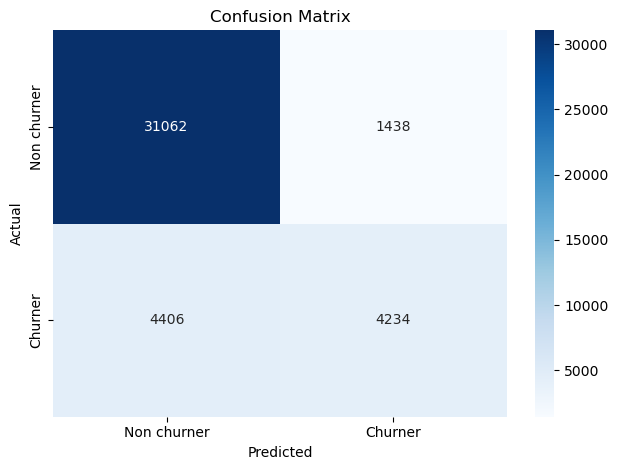

In [8]:
# confusion matrix
plt.title('Confusion matrix')
plot_confusionmatrix(y_test,y_pred_test)

From the confusion matrix, we can already deduce that k-NN performs better than Logistic Regression.

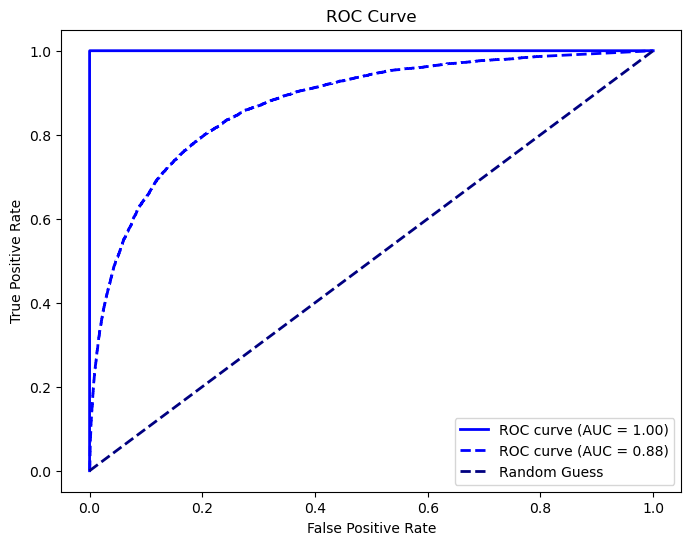

In [9]:
# ROC curve
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_probs_train)

# AUC
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='blue', lw=2, linestyle='--', label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test_lr = precision_score(y_test, y_pred_test)
# recall
recall_test_lr = recall_score(y_test, y_pred_test)
# f1-measure
f1_test_lr = f1_score(y_test, y_pred_test)

print('Precision on the test set is {}'.format(precision_test_lr))
print('Recall on the test set is {}'.format(recall_test_lr))
print('f1-measure on the test set is {}'.format(f1_test_lr))

Precision on the test set is 0.7464739069111425
Recall on the test set is 0.4900462962962963
f1-measure on the test set is 0.5916713247624372


In [11]:
import pickle

# save model
model_name='knn.pkl'
model_file=open(model_name,'wb')
pickle.dump(best_knn, model_file)
model_file.close()

# open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)